In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

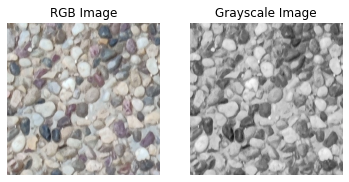

In [2]:
ImgPath = './data/gravelroad_1.jpg'
imgBGR = cv2.imread(ImgPath)
img = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2GRAY)
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB);
plt.figure()
plt.subplot(121); plt.imshow(imgRGB); plt.title('RGB Image'); plt.axis('off')
plt.subplot(122); plt.imshow(img, cmap='gray'); plt.title('Grayscale Image'); plt.axis('off')
plt.show()

In [3]:
img = np.array(img) # I prefer using numpy

In [4]:
def lbp_pixel(img, r, c):
    h, w = img.shape
    offsets = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]
    pixel = img[r, c]
    res = 0
    for (dr, dc) in offsets:
        nr, nc = r + dr, c + dc
        if nr < 0 or nr > h - 1 or nc < 0 or nc > w - 1:
            neighbor = 0
        else:
            neighbor = img[nr, nc]
        code = 0 if neighbor <= pixel else 1
        res = (res << 1) + code
    return res

In [5]:
testImg = np.array([
    [100, 101, 103],
    [40, 50, 80],
    [50, 60, 90]
], dtype=np.uint8)
testLbp = lbp_pixel(testImg, 1, 1)
print(testLbp, bin(testLbp))

252 0b11111100


In [6]:
def calc_lbp_img(img):
    imgLBP = np.zeros_like(img)
    h, w = img.shape
    for r in range(h):
        for c in range(w):
            imgLBP[r, c] = lbp_pixel(img, r, c)
    return imgLBP

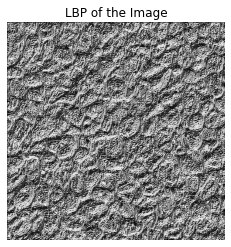

In [7]:
imgLBP = calc_lbp_img(img)
plt.figure()
plt.imshow(imgLBP, cmap='gray'); plt.title('LBP of the Image'); plt.axis('off')
plt.show()

In [8]:
def calc_lbp_hist(img, normalize=True, mask=None):
    imgLBP = calc_lbp_img(img)
    hist = cv2.calcHist([imgLBP], [0], mask, [256], [0, 256])
    if normalize:
        hist /= hist.sum()
    return hist.squeeze()

In [9]:
imgLBPHist = calc_lbp_hist(img)

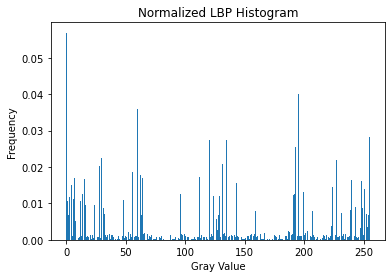

In [10]:
plt.figure()
plt.bar(np.arange(0, 256), imgLBPHist); plt.title('Normalized LBP Histogram');
plt.xlabel('Gray Value'); plt.ylabel('Frequency')
plt.show()

In [11]:
def lbp_histograms_distance(h1, h2):
    diff = 0.0
    for i in range(256):
        diff += abs(h1[i] - h2[i])
    return diff

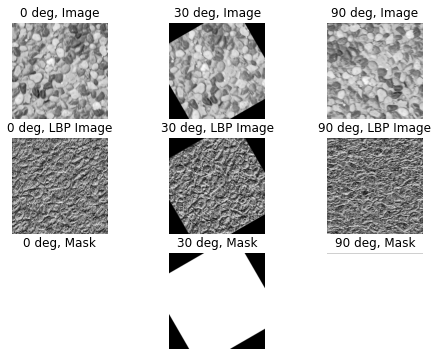

In [13]:
# To demonstrate the blank regions.
mask = np.ones_like(img)
h, w = img.shape
RotCenter = (w // 2, h // 2) # OpenCV uses (x, y)
plt.figure(figsize=(8, 6))
for idx, rotAngle in enumerate([0, 30, 90]):
    transformMat = cv2.getRotationMatrix2D(RotCenter, rotAngle, 1)
    transformImg = cv2.warpAffine(img, M=transformMat, dsize=(w, h))
    transformMask = cv2.warpAffine(mask, M=transformMat, dsize=(w, h))
    plt.subplot(3, 3, idx + 1)
    plt.title('{} deg, Image'.format(rotAngle)); plt.imshow(transformImg, cmap='gray'); plt.axis('off')
    plt.subplot(3, 3, 3 * 1 + idx + 1)
    plt.title('{} deg, LBP Image'.format(rotAngle)); plt.imshow(calc_lbp_img(transformImg), cmap='gray'); plt.axis('off')
    plt.subplot(3, 3, 3 * 2 + idx + 1);
    plt.title('{} deg, Mask'.format(rotAngle)); plt.imshow(transformMask, cmap='gray', vmin=0, vmax=1); plt.axis('off')
plt.show()

In [14]:
from tqdm import tqdm
mask = np.ones_like(img)
h, w = img.shape
RotAngles = np.arange(0, 360, 1)
RotCenter = (w // 2, h // 2) # OpenCV uses (x, y)
distances = []
for rotAngle in tqdm(RotAngles):
    transformMat = cv2.getRotationMatrix2D(RotCenter, rotAngle, 1)
    transformImg = cv2.warpAffine(img, M=transformMat, dsize=(w, h))
    transformMask = cv2.warpAffine(mask, M=transformMat, dsize=(w, h))
    transformImgHist = calc_lbp_hist(transformImg, normalize=True, mask=transformMask)
    maskedImgHist = calc_lbp_hist(img, normalize=True, mask=transformMask)
    dist = lbp_histograms_distance(maskedImgHist, transformImgHist)
    distances.append(dist)

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [15:59<00:00,  2.66s/it]


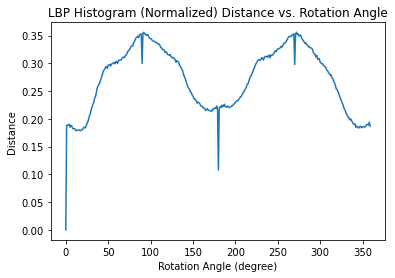

In [15]:
plt.figure()
plt.plot(RotAngles, distances); plt.title('LBP Histogram (Normalized) Distance vs. Rotation Angle')
plt.xlabel('Rotation Angle (degree)'); plt.ylabel('Distance')
plt.show()

Scale: 1x, Dist: 0.000
Scale: 1.25x, Dist: 0.303
Scale: 1.5x, Dist: 0.413


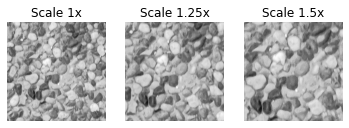

In [31]:
h, w = img.shape
Scales = [1, 1.25, 1.5]
ScaleCenter = (w // 2, h // 2) # OpenCV uses (x, y)
plt.figure()
for idx, scale in enumerate(Scales):
    transformImg = cv2.resize(img, None, fx=scale, fy=scale)
    newH, newW = transformImg.shape
    leftTopR, leftTopC = (newH - h) // 2, (newW - w) // 2
    # center crop
    transformImg = transformImg[leftTopR:leftTopR + h, leftTopC:leftTopC + w]
    plt.subplot(1, 3, idx + 1); plt.imshow(transformImg, cmap='gray'); plt.title('Scale {}x'.format(scale)); plt.axis('off')
    hist = calc_lbp_hist(transformImg, normalize=True)
    dist = lbp_histograms_distance(imgLBPHist, hist)
    print('Scale: {}x, Dist: {:.3f}'.format(scale, dist))
plt.show()